In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
SBA = pd.read_csv("../data/SBA_cleaned.csv", na_values='nan', index_col=None)
SBA.head()

,State,NAICS,NoEmp,NewExist,MIS_Status,SBA_GrPortion,RealEstate
0,in,45,4,2.0,P I F,0.80,0
1,in,62,7,1.0,P I F,0.75,0
2,ct,33,19,1.0,P I F,0.75,0
3,fl,81,1,2.0,P I F,0.80,0
4,nc,81,1,2.0,P I F,0.80,0


In [3]:
# Count the target variable
SBA['MIS_Status'].value_counts()

MIS_Status
P I F     391134
CHGOFF     97149
Name: count, dtype: int64

In [4]:
SBA.describe()

,NAICS,NoEmp,NewExist,SBA_GrPortion,RealEstate
count,488283.000000,488283.000000,488283.000000,488283.000000,488283.000000
mean,50.965858,9.991984,1.287745,0.683989,0.137588
std,17.645562,66.539363,0.452712,0.175399,0.344468
min,11.000000,0.000000,1.000000,0.028140,0.000000
25%,42.000000,2.000000,1.000000,0.500000,0.000000
50%,51.000000,4.000000,1.000000,0.750000,0.000000
75%,62.000000,9.000000,2.000000,0.850000,0.000000
max,92.000000,9999.000000,2.000000,1.000000,1.000000


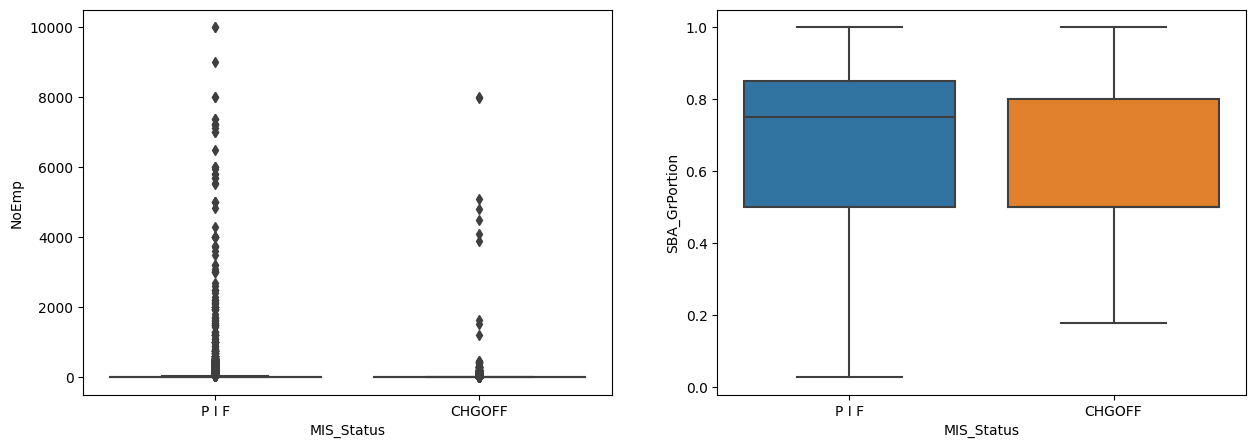

In [5]:
# Box plot for NoEmp and SBA_GrPortion
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='MIS_Status', y='NoEmp', data=SBA, ax=ax[0])
sns.boxplot(x='MIS_Status', y='SBA_GrPortion', data=SBA, ax=ax[1])
plt.show()

In [6]:
# MinMaxScaler for NoEmp and SBA_GrPortion
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
SBA[['NoEmp', 'SBA_GrPortion']] = scaler.fit_transform(SBA[['NoEmp', 'SBA_GrPortion']])

In [7]:
def outlier(datacolumn):
    sorted(datacolumn)
    Q1, Q3 = np.percentile(datacolumn, [25, 75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

In [8]:
# Remove outliers for NoEmp and SBA_GrPortion
low_NoEmp, up_NoEmp = outlier(SBA['NoEmp'])
low_SBA_GrPortion, up_SBA_GrPortion = outlier(SBA['SBA_GrPortion'])
SBA = SBA[(SBA['NoEmp'] > low_NoEmp) & (SBA['NoEmp'] < up_NoEmp)]
SBA = SBA[(SBA['SBA_GrPortion'] > low_SBA_GrPortion) & (SBA['SBA_GrPortion'] < up_SBA_GrPortion)]

In [9]:
SBA['MIS_Status'].value_counts()

MIS_Status
P I F     341719
CHGOFF     91620
Name: count, dtype: int64

In [10]:
seed = 500
# Take 50000 samples for each value of MIS_Status
SBA_1 = SBA[SBA['MIS_Status'] == "P I F"].sample(n=5000, random_state=seed)
SBA_0 = SBA[SBA['MIS_Status'] == "CHGOFF"].sample(n=5000, random_state=seed)
SBA = pd.concat([SBA_0, SBA_1], axis=0)

In [11]:
# Label encoding for MIS_Status before target encoding for state
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
SBA['MIS_Status'] = le.fit_transform(SBA['MIS_Status'])
# P I F: 1, CHGOFF: 0

In [12]:
SBA.head()

,State,NAICS,NoEmp,NewExist,MIS_Status,SBA_GrPortion,RealEstate
195550,ca,44,0.0001,2.0,0,0.742761,0
142477,ca,54,0.0002,1.0,0,0.485523,0
452616,wi,23,0.0001,1.0,0,0.485523,0
455118,nh,62,0.0003,1.0,0,0.845657,0
389698,ky,23,0.0010,2.0,0,0.742761,0


In [13]:
from sklearn import base
from sklearn.model_selection import KFold
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2023)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

In [14]:
targeState = KFoldTargetEncoderTrain('State','MIS_Status',n_fold=10)
SBA = targeState.fit_transform(SBA)
SBA.drop(['State'], axis=1, inplace=True)

Correlation between the new feature, State_Kfold_Target_Enc and, MIS_Status is 0.13841004812935978.


In [15]:
targetNaics = KFoldTargetEncoderTrain('NAICS','MIS_Status',n_fold=10)
SBA = targetNaics.fit_transform(SBA)
SBAdrop = SBA.drop(['NAICS'], axis=1, inplace=True)

Correlation between the new feature, NAICS_Kfold_Target_Enc and, MIS_Status is 0.12204395266298472.


In [16]:
X = SBA.drop(['MIS_Status'], axis=1)
y = SBA['MIS_Status']

In [17]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

Best k value: 7
Accuracy for best k value: 0.624
Classification Report for Best k value (7):
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1238
           1       0.64      0.60      0.62      1262

    accuracy                           0.62      2500
   macro avg       0.62      0.62      0.62      2500
weighted avg       0.62      0.62      0.62      2500



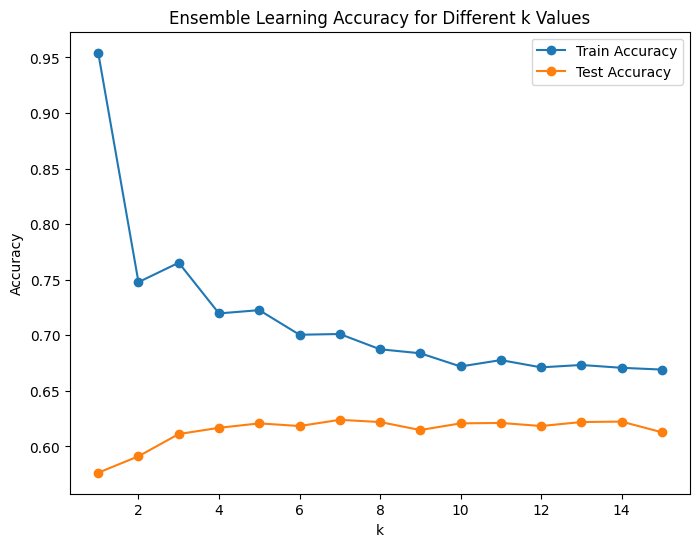

In [19]:
np.seed = 500
from sklearn.neighbors import KNeighborsClassifier

# Define the number of base classifiers in the ensemble
num_classifiers = 7

k_values = list(range(1, 16))
ensemble_train_accuracies = []
ensemble_test_accuracies = []

predictions = {}
classification_reports = {}

for k in k_values:
    # Create an empty list to store the base classifiers
    classifiers = []

    # Train the base classifiers on different subsets of the training data
    for i in range(num_classifiers):
        classifier = KNeighborsClassifier(n_neighbors=k)
        subset_indices = np.random.choice(len(X_train), size=int(0.75 * len(X_train)), replace=False)
        subset_features = X_train.iloc[subset_indices] 
        subset_targets = y_train.iloc[subset_indices]
        classifier.fit(subset_features, subset_targets)
        classifiers.append(classifier)

    # Make predictions using each base classifier and calculate their weights based on accuracy
    weights = []
    train_predictions = []
    test_predictions = []

    for classifier in classifiers:
        train_pred = classifier.predict(X_train)
        test_pred = classifier.predict(X_test)
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)
        weight = train_accuracy / sum(train_accuracy for _ in classifiers)
        weights.append(weight)
        train_predictions.append(train_pred)
        test_predictions.append(test_pred)

    # Combine the predictions using weighted voting for training set
    ensemble_train_predictions = np.zeros_like(train_predictions[0], dtype=np.float64)

    for i in range(len(classifiers)):
        ensemble_train_predictions += weights[i] * train_predictions[i]

    ensemble_train_predictions = np.round(ensemble_train_predictions)

    # Combine the predictions using weighted voting for test set
    ensemble_test_predictions = np.zeros_like(test_predictions[0], dtype=np.float64)

    for i in range(len(classifiers)):
        ensemble_test_predictions += weights[i] * test_predictions[i]

    ensemble_test_predictions = np.round(ensemble_test_predictions)

    # Store the predictions in a dictionary
    predictions[k] = ensemble_test_predictions
    
    # Evaluate the ensemble's accuracy for training and test sets
    ensemble_train_accuracy = accuracy_score(y_train, ensemble_train_predictions)
    ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_predictions)
    ensemble_train_accuracies.append(ensemble_train_accuracy)
    ensemble_test_accuracies.append(ensemble_test_accuracy)

    # Store the classification report for the current k value
    report = classification_report(y_test, ensemble_test_predictions)
    classification_reports[k] = report

# Best k value for the ensemble model based on test accuracy
best_k = k_values[ensemble_test_accuracies.index(max(ensemble_test_accuracies))]
print(f'Best k value: {best_k}')
print(f'Accuracy for best k value: {max(ensemble_test_accuracies)}')

# Print the classification report for the best k value
best_k_report = classification_reports[best_k]
print(f'Classification Report for Best k value ({best_k}):')
print(best_k_report)

# Plot the ensemble accuracies for different k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, ensemble_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(k_values, ensemble_test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Ensemble Learning Accuracy for Different k Values')
plt.legend()
plt.show()